In [1]:
import pandas as pd
import numpy as np
# read csv from panda
# train a regressor to predict the voltage
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from chemparse import parse_formula
# Mendeleev+
import matminer.featurizers.composition as comp
from matminer import featurizers
import matminer
from pymatgen.core import Composition


In [2]:
train_df = pd.read_csv('../datasets/aflow/train.csv')
test_df = pd.read_csv('../datasets/aflow/test.csv')
val_df = pd.read_csv('../datasets/aflow/val.csv')

In [3]:
stats_list = ['minimum', 'maximum', 'range', 'mean', 'std_dev']
deml_list = ['molar_vol']
deml_f = comp.ElementProperty('deml', deml_list, stats_list)
magpie_list = ['Number', 'MendeleevNumber', 'AtomicVolume', 'AtomicWeight',
               'Column', 'Row', 'Density',
               'NdValence', 'NfValence',
               'NpValence', 'NsValence', 'NValence']
magpie_f = comp.ElementProperty('magpie', magpie_list, stats_list)
pymatgen_list = ['block', 'group']
pymatgen_f = comp.ElementProperty('pymatgen', pymatgen_list, stats_list)

def get_encoding_data(data_original, encoding_func):
    result = pd.DataFrame([])
    if type(data_original) == pd.DataFrame:
        for f in data_original.columns:
            result = result.join(encoding_func(data_original[f], suffix='_' + f), how='outer')
    else:
        result = encoding_func(data_original)
    # result['formula'] = data_original
    return result

def mendeleev_encoding(formulas, suffix=''):
    """
    in: formulas: an array-like of chemical formulas
    out: a dataframe of formula encoding
    """
    formulas_base = pd.Series(train_df['formula'])
    encoding_base = pd.DataFrame(formulas_base.apply(lambda x: parse_formula(x)).values.tolist())
    encoding_base = encoding_base.fillna(0).rename(columns=lambda x: x + suffix)
    if type(formulas) != pd.Series:
        formulas = pd.Series(formulas)
    encoding = pd.DataFrame(formulas.apply(lambda x: parse_formula(x)).values.tolist())
    encoding = encoding.fillna(0).rename(columns=lambda x: x + suffix)

    encoding = encoding.reindex(columns=encoding_base.columns, fill_value=0)
    return encoding

def get_matminer_features(f):
    try:
        features = deml_f.featurize(f) + magpie_f.featurize(f) + pymatgen_f.featurize(f)
        return np.array(features)
    except Exception:
        arr = np.zeros(75)
        arr[:] = np.nan
        return arr

In [4]:
# mendeleev_data = get_encoding_data(train_df['formula'], mendeleev_encoding)
mendeleev_train = get_encoding_data(train_df['formula'], mendeleev_encoding)
mendeleev_train = mendeleev_train.dropna()
mendeleev_val = get_encoding_data(val_df['formula'], mendeleev_encoding)
mendeleev_val = mendeleev_val.dropna()
mendeleev_test = get_encoding_data(test_df['formula'], mendeleev_encoding)
mendeleev_test = mendeleev_test.dropna()

In [5]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes = [128, 128, 128], random_state=0, max_iter=2000, activation='tanh', solver='adam', batch_size=16, validation_fraction=0).fit(
  mendeleev_train.to_numpy(), train_df['target'].to_numpy()
)

In [7]:
# best para: [400, 400, 400, 400]
preds = mlp.predict(mendeleev_test.to_numpy())
print("MAE: {}".format(mean_absolute_error(test_df['target'], preds)))
print("R2: {}".format(r2_score(test_df['target'], preds)))

MAE: 11.24737903541127
R2: 0.9063794220194336


In [8]:
import generalized_rashomon_set as grs
explainer = grs.explainers.fis_explainer(mlp, input=mendeleev_test.to_numpy()
, output=test_df['target'].to_numpy()
, epsilon_rate=0.05, loss_fn='mean_absolute_error', n_order=2, delta=0.1, torch_input=False)

2024-08-09 10:30:14,186 INFO config <module> The output directory is /home/sichao/PycharmProjects/DiverseExplantionsDigitalDiscovery/case-1-aflow-bulk/../results
 The log directory is /home/sichao/PycharmProjects/DiverseExplantionsDigitalDiscovery/case-1-aflow-bulk/../logs
2024-08-09 10:30:14,191 INFO _explainer __init__ You can call function load_results(explainer, results_path="") to load trained results if exist


In [ ]:
explainer.ref_explain()

## Plot the heat map

In [10]:
feature_names = mendeleev_train.columns.values

In [11]:
matrix = np.zeros((len(explainer.ref_analysis['ref_main_effects']),len(explainer.ref_analysis['ref_main_effects'])))

In [12]:
for i in explainer.ref_analysis['ref_fis']:
    matrix[i[0][0]][i[0][1]] = i[1]

In [13]:
for i in range(len(explainer.ref_analysis['ref_main_effects'])):
    matrix[i][i] = explainer.ref_analysis['ref_main_effects'][i]

In [14]:
matrix = matrix + matrix.T - np.diag(matrix.diagonal())# matrix = matrix[38:57,38:57]

In [15]:
mask = np.eye(matrix.shape[0], dtype=bool)

In [40]:
# Create a dictionary mapping element symbols to their atomic numbers
element_to_number = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18, 'K': 19, 'Ca': 20,
    'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30,
    'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40,
    'Nb': 41, 'Mo': 42, 'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 'Pr': 59, 'Nd': 60,
    'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66, 'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70,
    'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80,
    'Tl': 81, 'Pb': 82, 'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92, 'Np': 93, 'Pu': 94, 'Am': 95, 'Cm': 96, 'Bk': 97, 'Cf': 98, 'Es': 99, 'Fm': 100,
    'Md': 101, 'No': 102, 'Lr': 103, 'Rf': 104, 'Db': 105, 'Sg': 106, 'Bh': 107, 'Hs': 108, 'Mt': 109, 'Ds': 110,
    'Rg': 111, 'Cn': 112, 'Nh': 113, 'Fl': 114, 'Mc': 115, 'Lv': 116, 'Ts': 117, 'Og': 118
}

def sort_periodic_table_matrix(matrix, element_names):
    # Create a list of (element, index) tuples
    element_indices = [(element, i) for i, element in enumerate(element_names)]

    # Sort the list based on atomic numbers
    sorted_indices = sorted(element_indices, key=lambda x: element_to_number[x[0]])

    # Extract the sorted indices
    new_order = [i for _, i in sorted_indices]

    # Reorder the matrix rows and columns
    sorted_matrix = matrix[new_order][:, new_order]

    # Get the sorted element names
    sorted_elements = [element for element, _ in sorted_indices]

    return sorted_matrix, sorted_elements

In [41]:
sorted_matrix, sorted_elements = sort_periodic_table_matrix(matrix, feature_names)

/tmp/ipykernel_1279637/1916980709.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar_top = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.01, anchor=(0.5, 0.5), )
/tmp/ipykernel_1279637/1916980709.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar_right = fig.colorbar(ax.collections[1], ax=ax, orientation='vertical', pad=0.01, anchor=(0.5, 0.5))


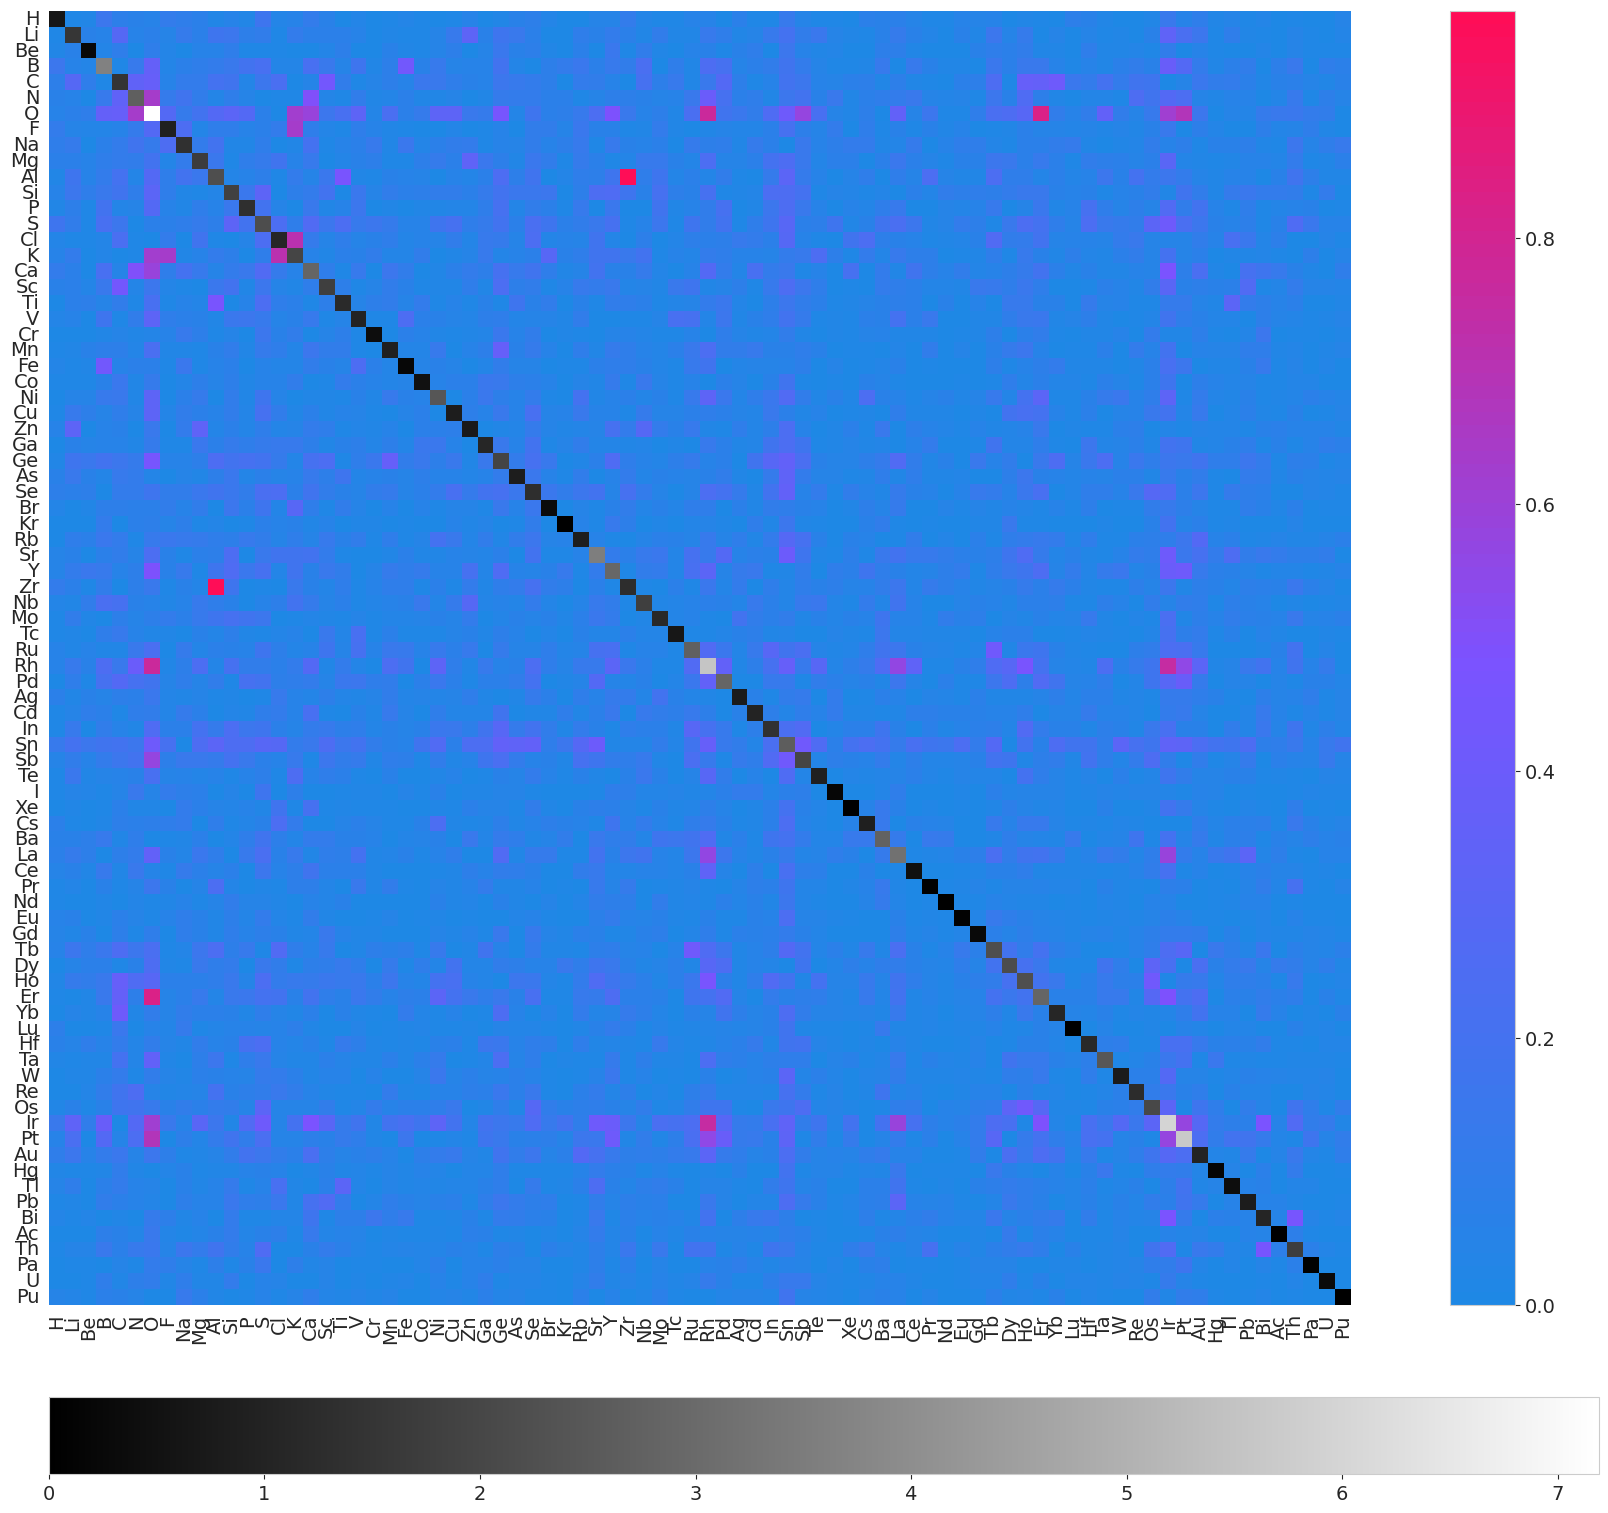

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
fig, ax = plt.subplots(figsize=(20,20))
plt.grid(False)
ax.grid(False)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#1E88E5", '#7C52FF', "#ff0d57"], N=100)
# norm = plt.Normalize(fis_in_r_df_long['Loss'].min(), explainer.loss + explainer.epsilon)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# Plot the heatmap for the diagonal
sns.heatmap(abs(sorted_matrix), mask=~mask, cbar=False, cmap='gray', xticklabels=sorted_elements, yticklabels=sorted_elements)

# Plot the heatmap for the rest
sns.heatmap(abs(sorted_matrix), mask=mask, cbar=False, cmap=cmap , xticklabels=sorted_elements, yticklabels=sorted_elements)

# Create a colorbar at the top for the diagonal
cbar_top = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', pad=0.01, anchor=(0.5, 0.5), )

# Create a colorbar at the right for the rest
cbar_right = fig.colorbar(ax.collections[1], ax=ax, orientation='vertical', pad=0.01, anchor=(0.5, 0.5))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
cbar_top.ax.tick_params(labelsize=14)
cbar_right.ax.tick_params(labelsize=14)
plt.savefig('Mendeleev-MLP-MR-heatmap-aflow.png', dpi=300, bbox_inches='tight')
plt.show()


## Plot the periodic table from https://github.com/Andrew-S-Rosen/periodic_trends

In [16]:
from periodic_trends import plotter
# Assuming mendeleev_data is your DataFrame and explainer.ref_analysis['ref_main_effects'] is your dictionary
main_effects = explainer.ref_analysis['ref_main_effects']

# Convert the dictionary and the column values into a DataFrame
df = pd.DataFrame(feature_names)
df = df.assign(column_values=main_effects)

# Save the DataFrame into a CSV file
df.to_csv('ele_importance_aflow.csv', index=False, header=False)


In [40]:
plt.style.use('default')
plotter("ele_importance_aflow.csv", cmap="viridis", output_filename='test.html', extended=True)

2024-06-24 15:13:01,210 INFO state output_file Session output file 'test.html' already exists, will be overwritten.


figure(id='p1179', ...)